In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.densenet import preprocess_input

In [2]:
# Imports for image transformations
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation

In [3]:
import numpy as np

X_train = np.load('X_traindl_with_masks.npy')
y_train = np.load('y_traindl_with_masks.npy')

X_val = np.load('X_valdl_with_masks.npy')
y_val = np.load('y_valdl_with_masks.npy')


In [ ]:

X_test = np.load('X_testdl_with_masks.npy')
y_test = np.load('y_testdl_with_masks.npy')

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(21852, 224, 224, 1)
(21852, 4)
(5463, 224, 224, 1)
(5463, 4)
(3176, 224, 224, 1)
(3176, 4)


In [4]:
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)


In [ ]:
X_test = np.repeat(X_test, 3, axis=-1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01, verbose=1, mode='min', monitor='val_loss')
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.01, factor=0.1, cooldown=4, verbose=1)

In [5]:

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [ ]:
X_test = preprocess_input(X_test)
print(np.unique(y_train))

In [10]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze weights initially

for layer in base_model.layers[-4:]:
    layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)  # classification

dense_model = Model(inputs=inputs, outputs=outputs)
dense_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
training_history = dense_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, verbose=1, callbacks=[early_stopping, reduce_learning_rate], shuffle=True)

MemoryError: Unable to allocate 12.3 GiB for an array with shape (21852, 224, 224, 3) and data type float32

In [68]:
dense_model.save('../models/densenet121_mask_model.keras')

In [62]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = dense_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(np.unique(y_pred_classes))


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step
[0 1 2 3]


In [63]:
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)
print("y_pred vals:", np.unique(y_pred))
y_true = np.argmax(y_test, axis=1)
print("y_true vals:", np.unique(y_true))

y_pred shape: (3176, 4)
y_test shape: (3176, 4)
y_pred vals: [1.0589370e-08 2.9399072e-08 5.1221313e-08 ... 9.9999452e-01 9.9999726e-01
 9.9999762e-01]
y_true vals: [0 1 2 3]


In [64]:
print(classification_report(y_true, y_pred_classes, target_names=['0', '1', '2', '3'], zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1529
           1       0.68      0.57      0.62       543
           2       0.79      0.79      0.79       902
           3       0.89      0.87      0.88       202

    accuracy                           0.80      3176
   macro avg       0.80      0.78      0.79      3176
weighted avg       0.80      0.80      0.80      3176



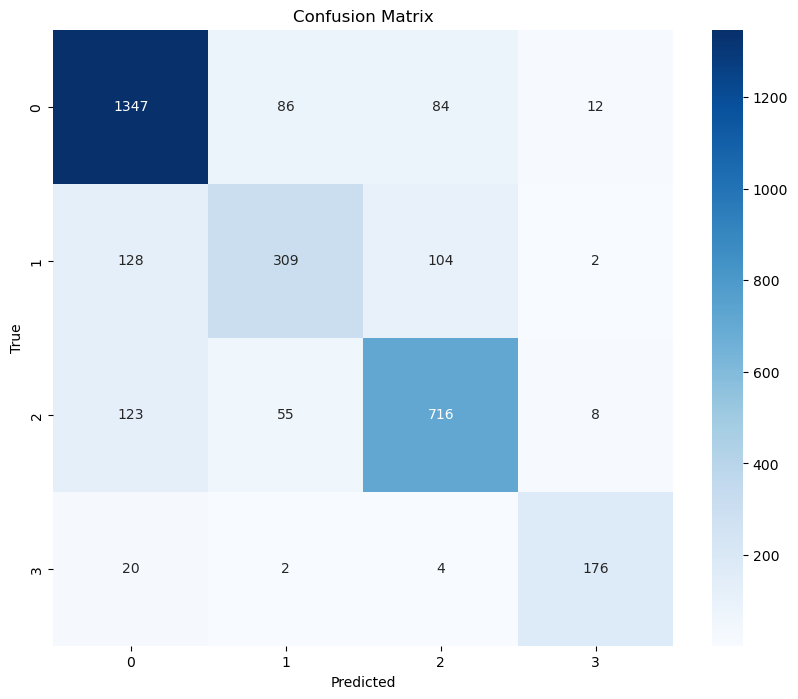

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") #, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [32]:
from tensorflow.keras.models import load_model
unfrozen_model = load_model('../models/densenet121_model_trainable.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

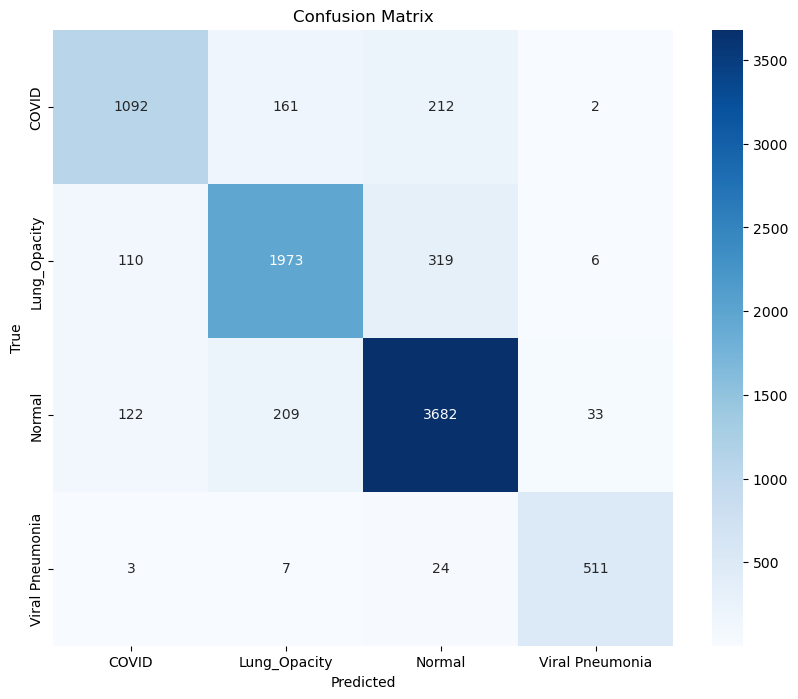

In [33]:
y_true1 = []
y_pred1 = []

for images, labels in val_ds:
    preds = unfrozen_model.predict(images)
    y_true1.extend(labels.numpy())
    y_pred1.extend(np.argmax(preds, axis=1))

print(classification_report(y_true1, y_pred1, target_names=class_names))

cm = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [34]:
print(classification_report(y_true1, y_pred1, target_names=class_names))

                 precision    recall  f1-score   support

          COVID       0.82      0.74      0.78      1467
   Lung_Opacity       0.84      0.82      0.83      2408
         Normal       0.87      0.91      0.89      4046
Viral Pneumonia       0.93      0.94      0.93       545

       accuracy                           0.86      8466
      macro avg       0.86      0.85      0.86      8466
   weighted avg       0.86      0.86      0.86      8466

